### Student Details

### Student Name: Aidan Keeshan
### Student ID: 18200117

You may add two extra libraries: one to make a train-test split and one to perform a grid search

In [31]:
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import svm
import math

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning,UserWarning))

Sample code to plot SVM margin, 'gutters' and support vectors

In [2]:
def plot_bound(X_train,y_train,clf,title):
    ###############
    c = np.repeat('forestgreen', len(y_train))
    c[np.where(y_train==1)] = 'skyblue'
    ###############
    plt.scatter(X_train[:, 0], X_train[:, 1], c=c, s=30)
    plt.title(title)
    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    Z = clf.best_estimator_.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.best_estimator_.support_vectors_[:, 0], clf.best_estimator_.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

def plot_eout(X_test,y_test,clf,title):
    ###############
    c = np.repeat('forestgreen', len(y_test))
    c[np.where(y_test==1)] = 'skyblue'
    ###############
    y_hat = clf.predict(X_test)
    diff = np.not_equal(y_test,y_hat)
    c[diff] = 'red'
    plt.scatter(X_test[:, 0], X_test[:, 1], c=c, s=30)
    plt.title(title+' Eout: {:2f}'.format(np.sum(diff)/len(diff)))

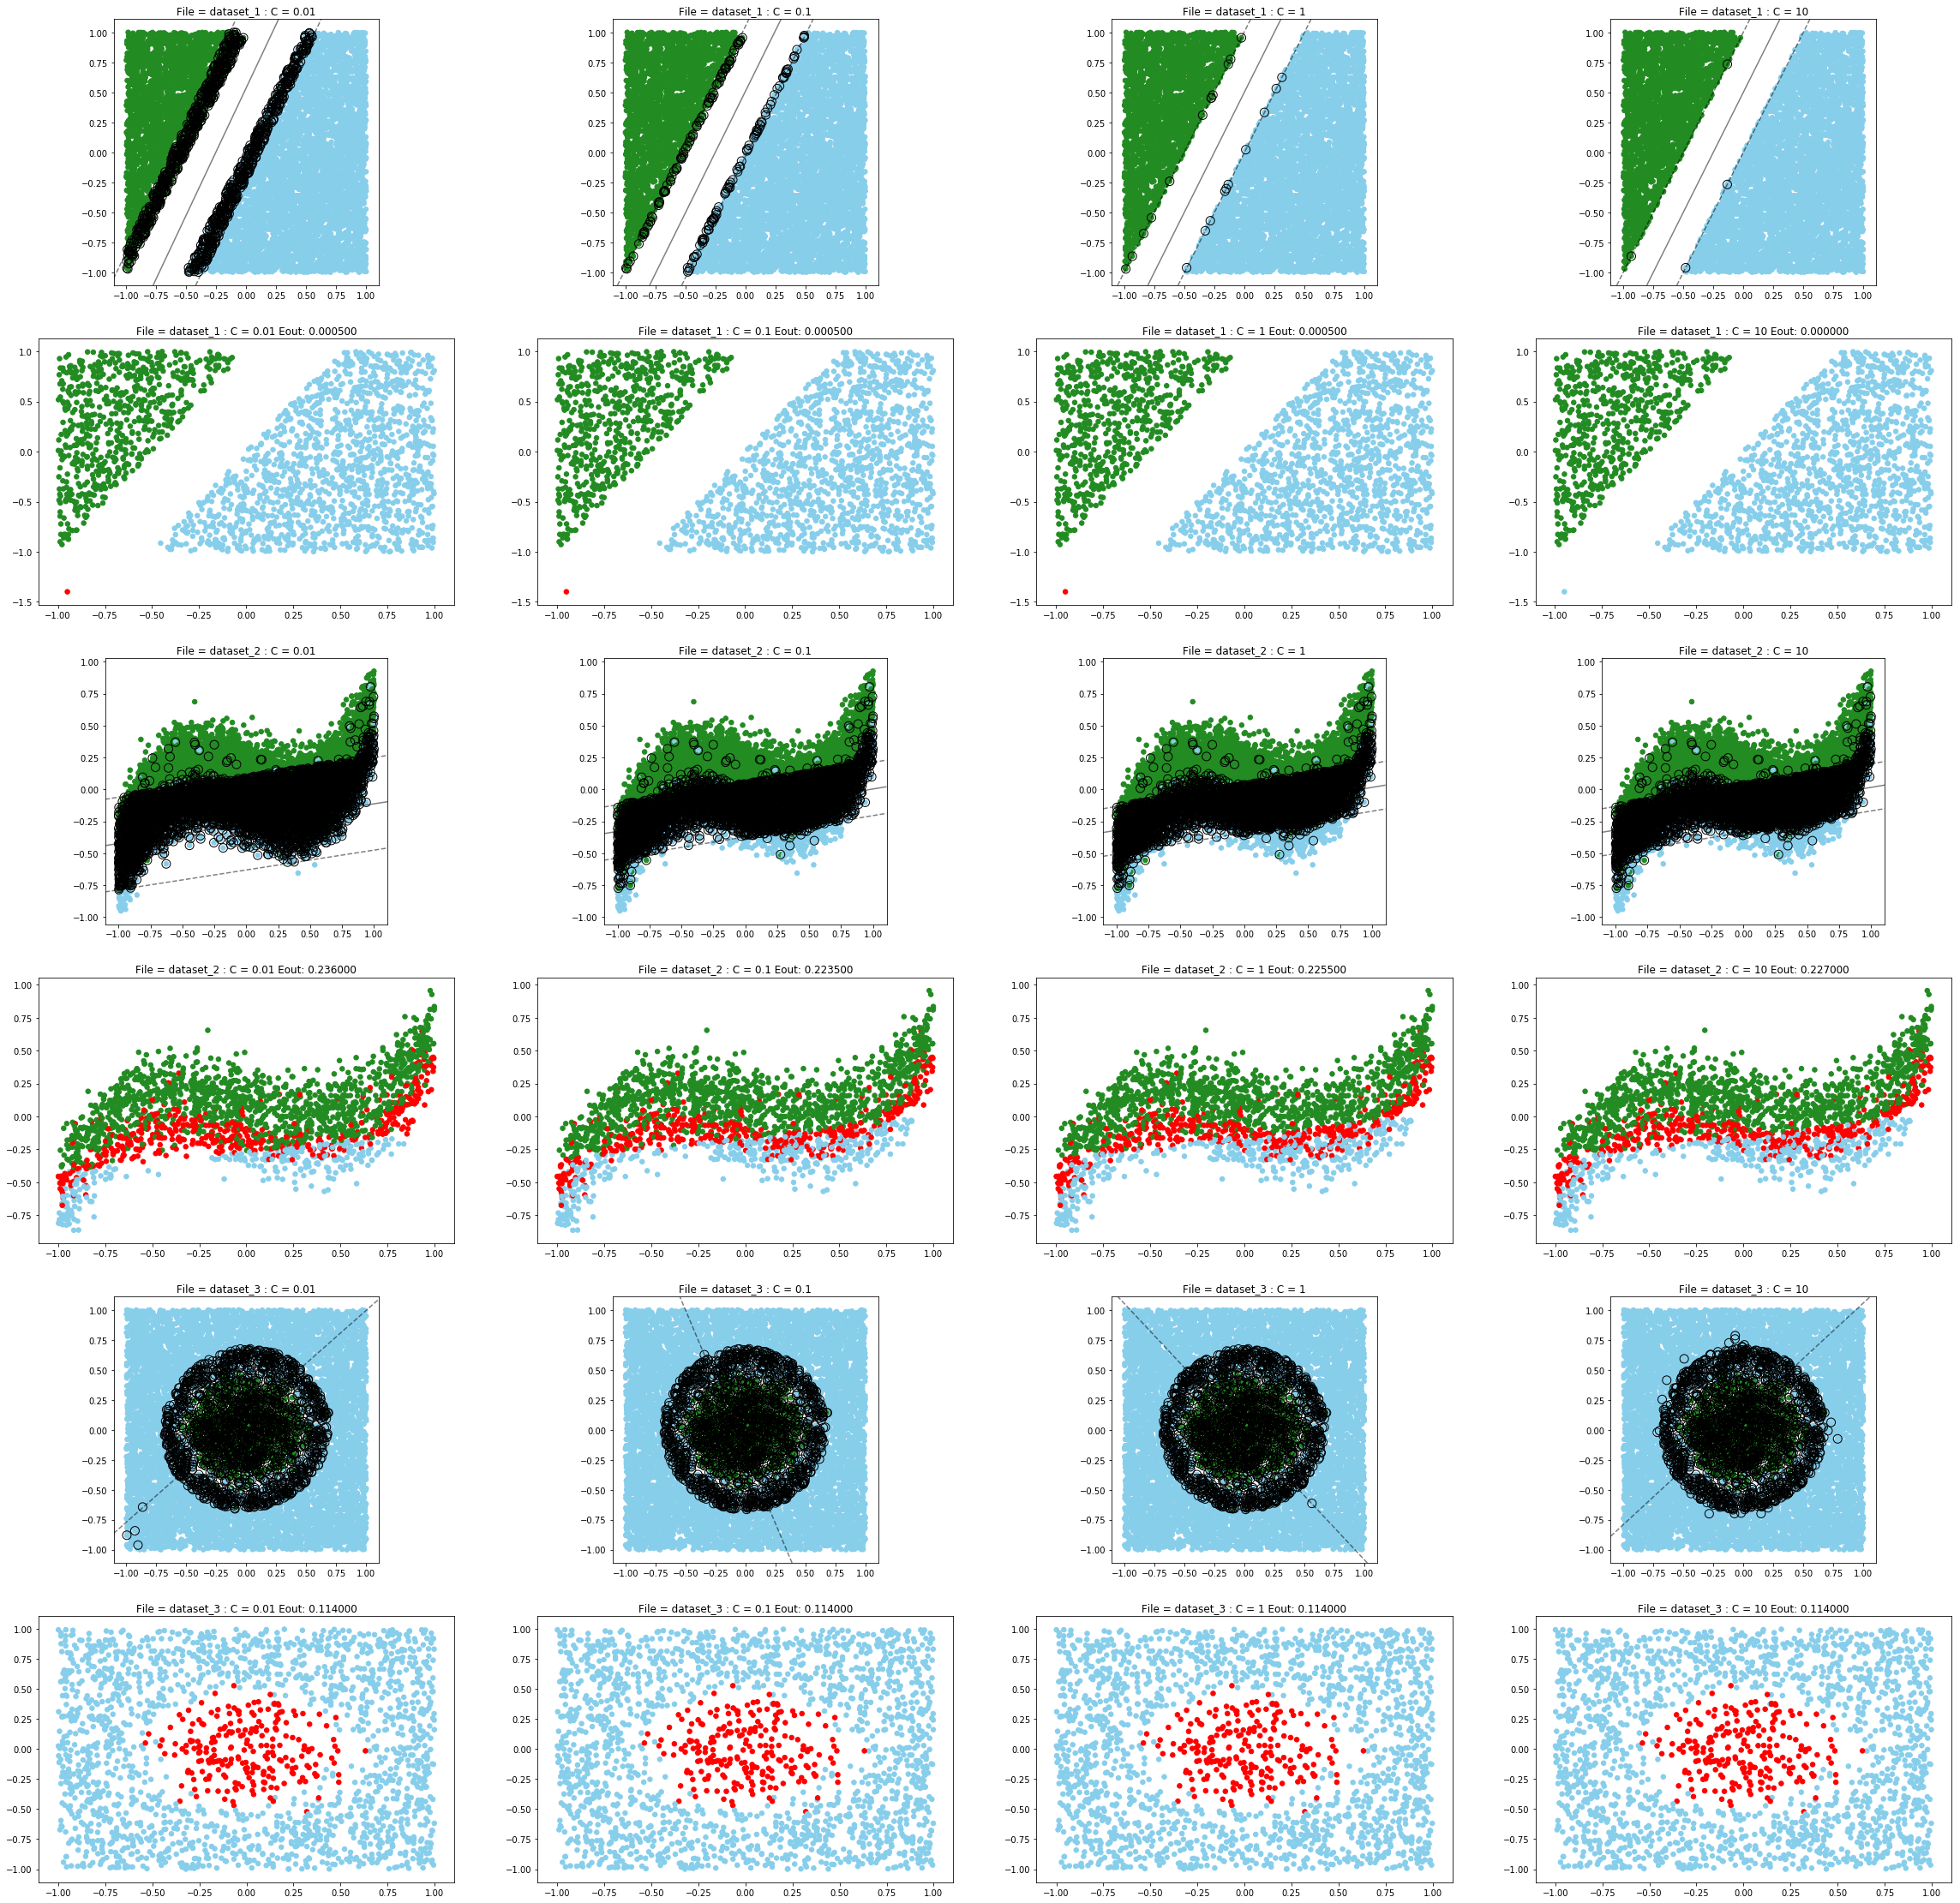

In [3]:
from sklearn.model_selection import train_test_split
from dask_searchcv import GridSearchCV

def import_csv(src_csv):
    ds = np.genfromtxt(src_csv, delimiter=',',skip_header=1,dtype=[('index','u4'),('VAR1','f8'),('VAR2','f8'),('TARGET','u1')])
    return train_test_split(np.c_[ds['VAR1'],ds['VAR2']], ds['TARGET'], test_size=0.2, random_state=0)

data = {}

for csv_n in [1,2,3]:
    key = 'dataset_'+str(csv_n)
    data[key] = import_csv(key+'.csv')

f = plt.figure(figsize=(40,40))
i = -3
for key in data:
    i += 4
    for c in [0.01,0.1,1,10]:
        GS = GridSearchCV(svm.SVC(), {'kernel':['linear'],'C': [c]},cv=3,n_jobs=-1)
        clf = GS.fit(data[key][0],data[key][2])
        ax = f.add_subplot(6,4,i)
        plot_bound(data[key][0],data[key][2],clf,'File = {} : C = {}'.format(key,c))
        ax = f.add_subplot(6,4,i+4)
        plot_eout(data[key][1],data[key][3],clf,'File = {} : C = {}'.format(key,c))
        i += 1

In [ ]:
f = plt.figure(figsize=(40,8))
GS_results = []
for i, key in enumerate(data.keys()):
    params = {'kernel': ['linear','rbf','sigmoid'],'C': [1,10,33,100], 'gamma': [0.0001, 0.001,1,10]}
    if i == 2:        
        params = {'kernel': ['poly'],'C': [1,10], 'degree':[2,3,4]}
    GS = GridSearchCV(svm.SVC(),params,cv=10,return_train_score=True)
    clf = GS.fit(data[key][0],data[key][2])
    GS_results.append(GS.cv_results_)
    ax = f.add_subplot(1,3,i+1)
    plot_bound(data[key][0],data[key][2],clf,'File = {} : C = {}\nThe best parameters are {} with a score of {:.2f}'.format(key,c,GS.best_params_, GS.best_score_))
f.show()

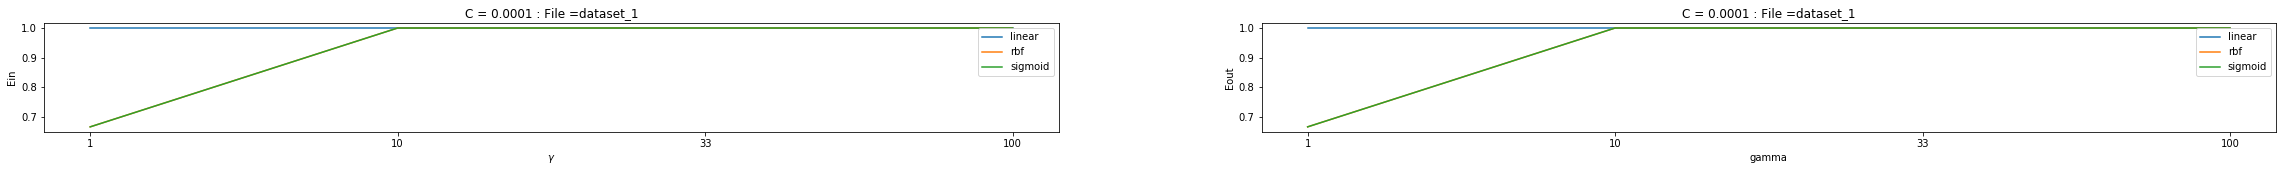

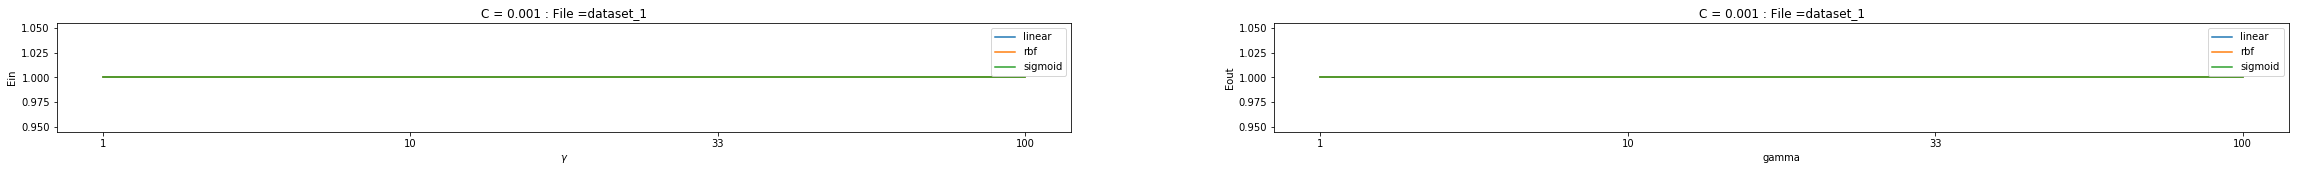

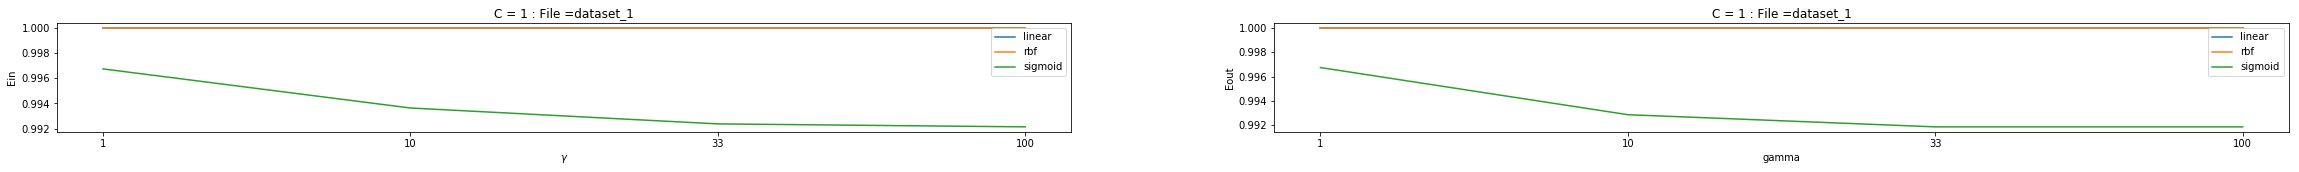

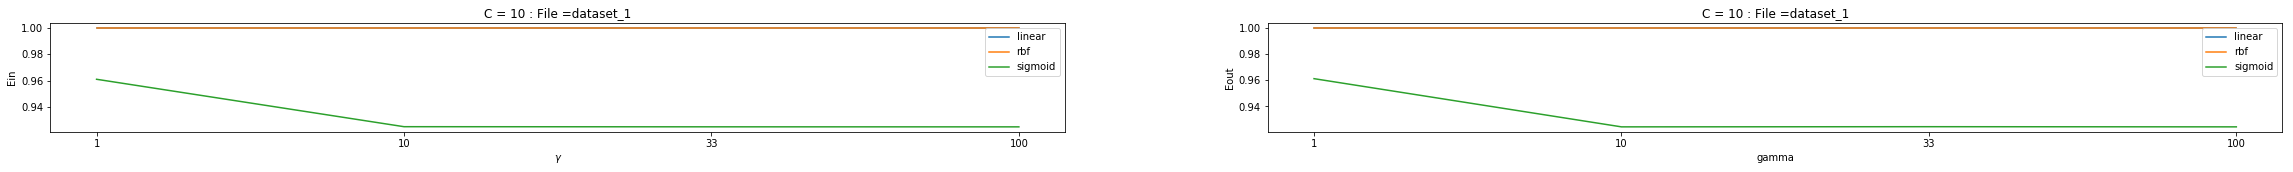

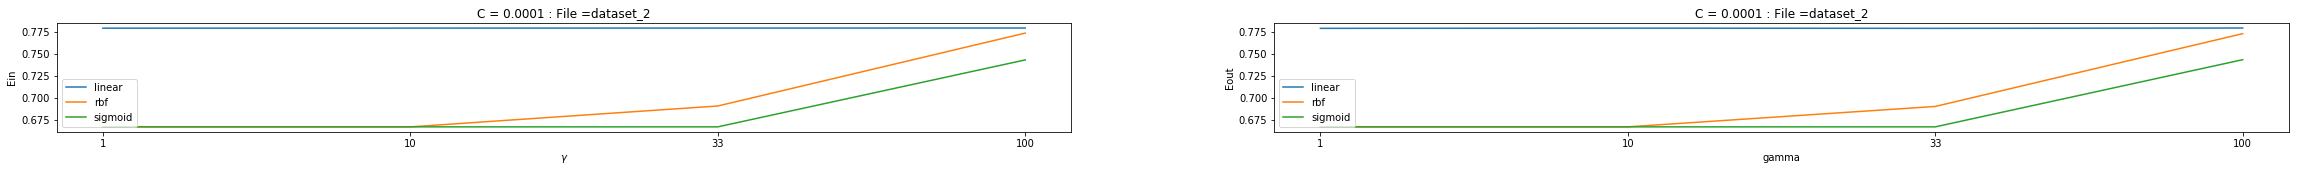

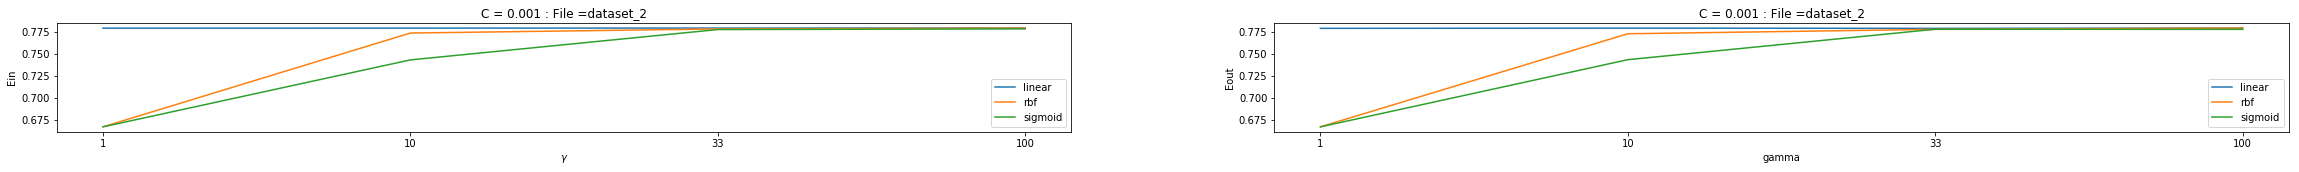

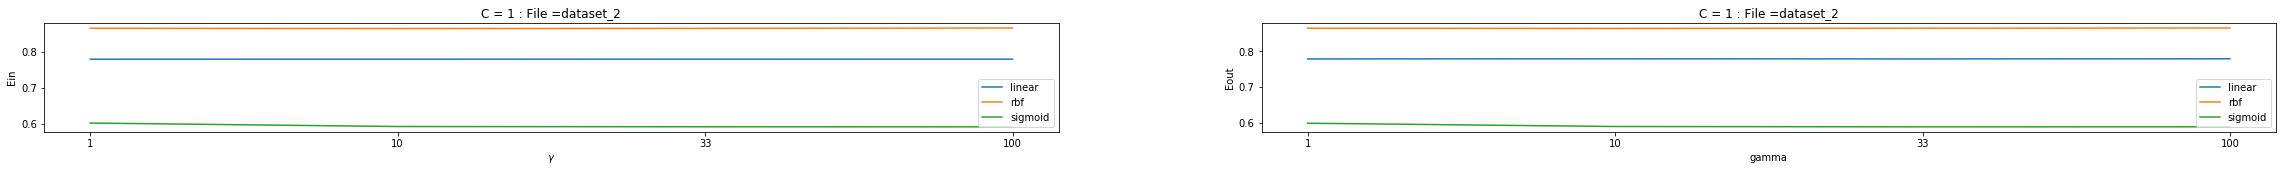

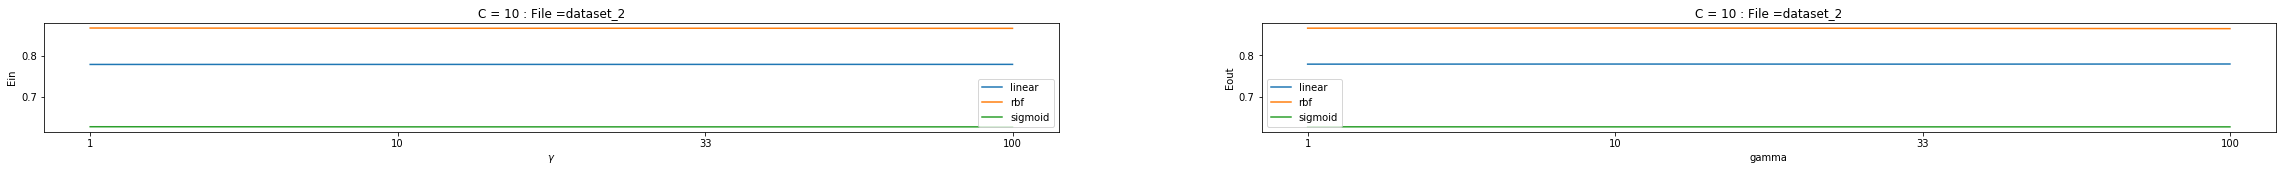

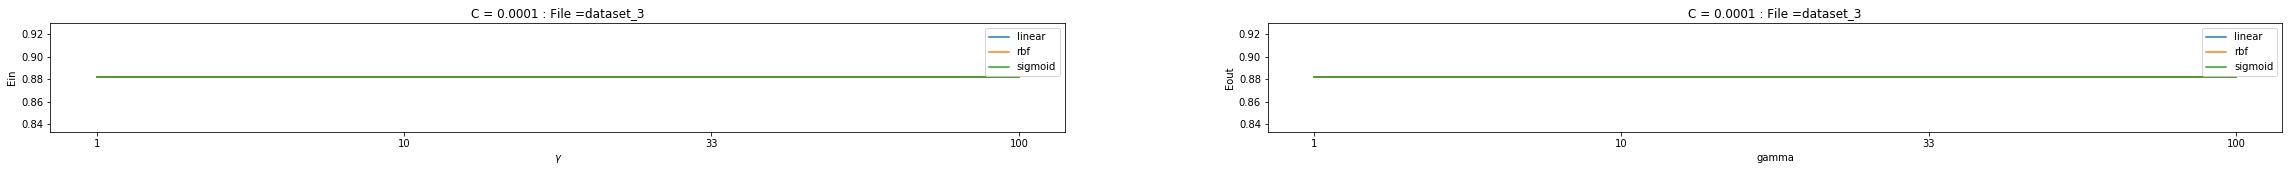

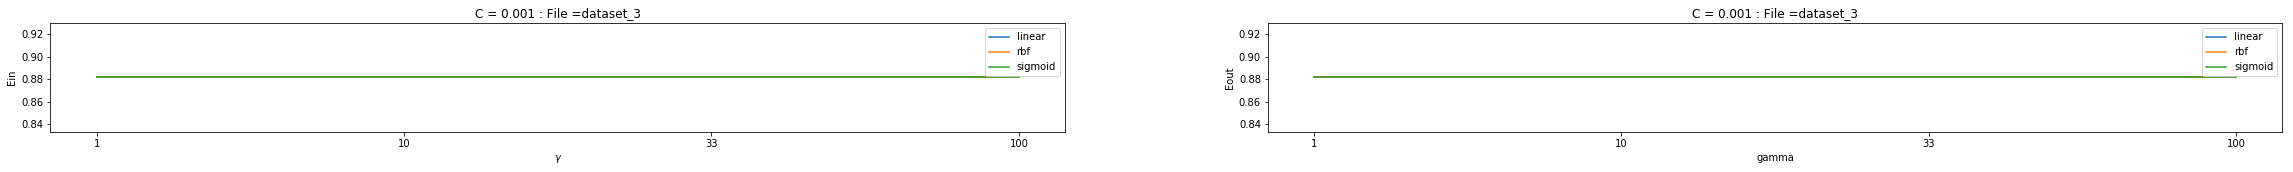

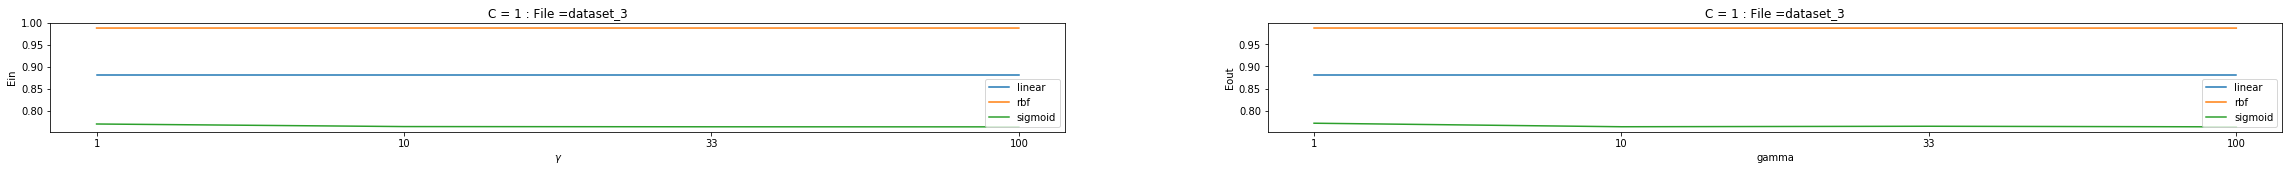

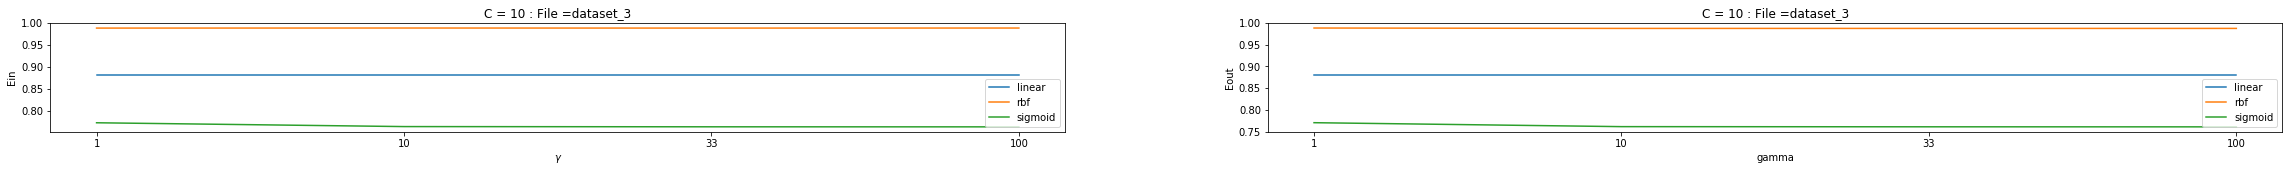

In [13]:
def plot_grid(res,file):
    i_s = np.unique(res[:,3])
    j_s = np.unique(res[:,4])

    for i in i_s:
        f = plt.figure(figsize=(40,2))
        for j in j_s:
            plt_data = res[(res[:,3] == i) & (res[:,4] == j)]
            ax = f.add_subplot(1,2,1)
            ax.plot(plt_data[:,2],plt_data[:,0].astype(float),label=j)
            ax.set_title("C = "+i+" : File ="+file)
            ax.set_ylabel("Ein")
            ax.set_xlabel(r'$\gamma$')
            ax.legend()
            ax = f.add_subplot(1,2,2)
            ax.plot(plt_data[:,2],plt_data[:,1].astype(float),label=j)
            ax.set_title("C = "+i+" : File ="+file)
            ax.set_ylabel("Eout")
            ax.set_xlabel('gamma')
            ax.legend()
        f.show()
        ax = None

for i in [1,2,3]:
    results = GS_results[i-1]
    ein = results['mean_train_score']
    eout = results['mean_test_score']
    np_values = np.c_[ein,eout,np.array([list(p.values()) for p in results['params']])]
    plot_grid(np_values,"dataset_"+str(i))

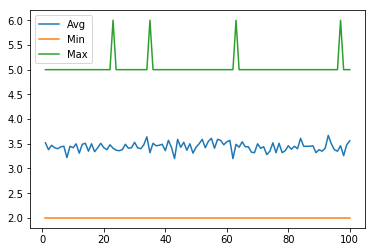

In [6]:
def run_exp():
    x1 = np.random.uniform(1, 1.2, 7)
    y1 = np.random.uniform(-0.5, 0.5, 7)
    for i in range(0,2):
        x1[i]  = 1
    s1 = np.c_[x1,y1]

    x2 = np.random.uniform(-1.2, -1.0, 8)
    y2 = np.random.uniform(-0.5, 0.5, 8)
    for i in range(0,3):
        x2[i]  = -1
    s2 = np.c_[x2,y2]
    s = np.concatenate((s1, s2))
    y = np.zeros(15)
    for i in range(0,7):
        y[i] = 1
    return s,y

num_supp_avg = []
num_supp_min = []
num_supp_max = []
for c in range(1,101):
    num_supp = []
    clf = svm.SVC(C=c, kernel='linear')
    for i in range(0,100):
        s,y = run_exp()
        clf.fit(s, y)
        num_supp.append(len(clf.support_vectors_))
    num_supp_avg.append(np.mean(num_supp))
    num_supp_min.append(np.min(num_supp))
    num_supp_max.append(np.max(num_supp))
plt.plot(range(1,101),num_supp_avg,label='Avg')
plt.plot(range(1,101),num_supp_min,label='Min')
plt.plot(range(1,101),num_supp_max,label='Max')
plt.legend()
plt.show()

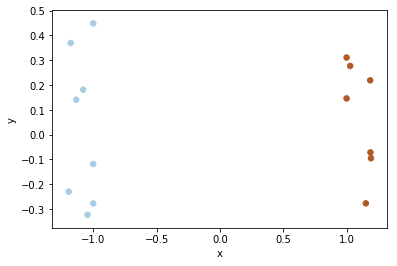

In [7]:
s,y = run_exp()
plt.scatter(s[:, 0], s[:, 1], c=y, s=30, cmap=plt.cm.Paired)
plt.xlabel("x")
plt.ylabel("y")
#plt.show()
#plt.draw()
plt.savefig('scatter.png', dpi=100)

In [8]:
clf = svm.SVC(C=10, kernel='linear')
clf.fit(s, y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

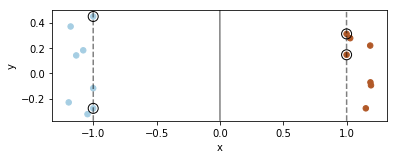

In [9]:
plt.scatter(s[:, 0], s[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
ax.set_aspect(aspect=1)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,linewidth=1, facecolors='none', edgecolors='k')
ax.set_xlabel("x")
ax.set_ylabel("y")
#plt.show()
plt.savefig('scatter_boundary.png', dpi=100)

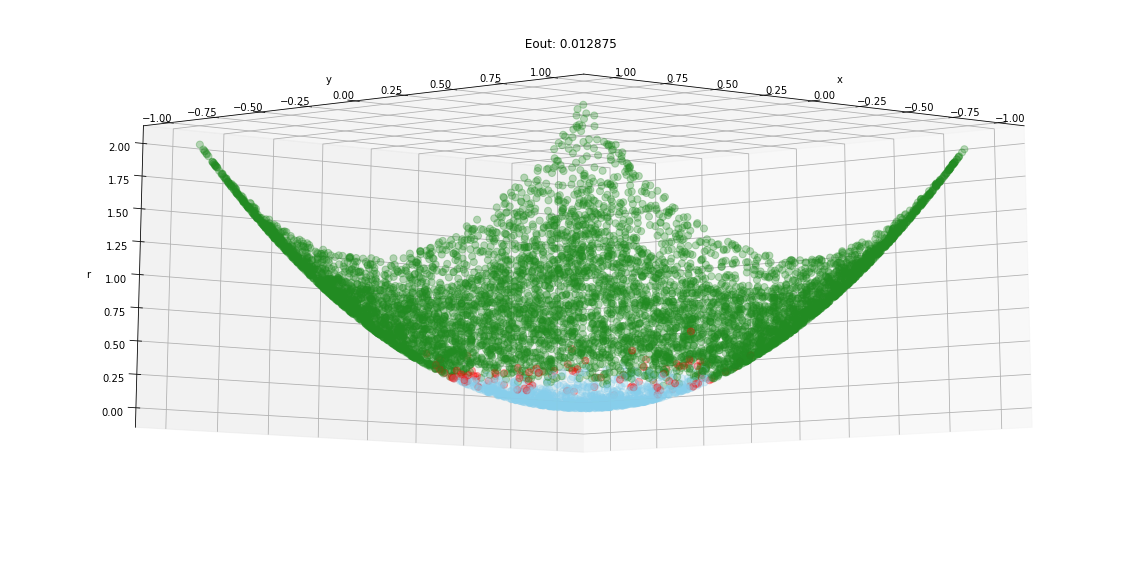

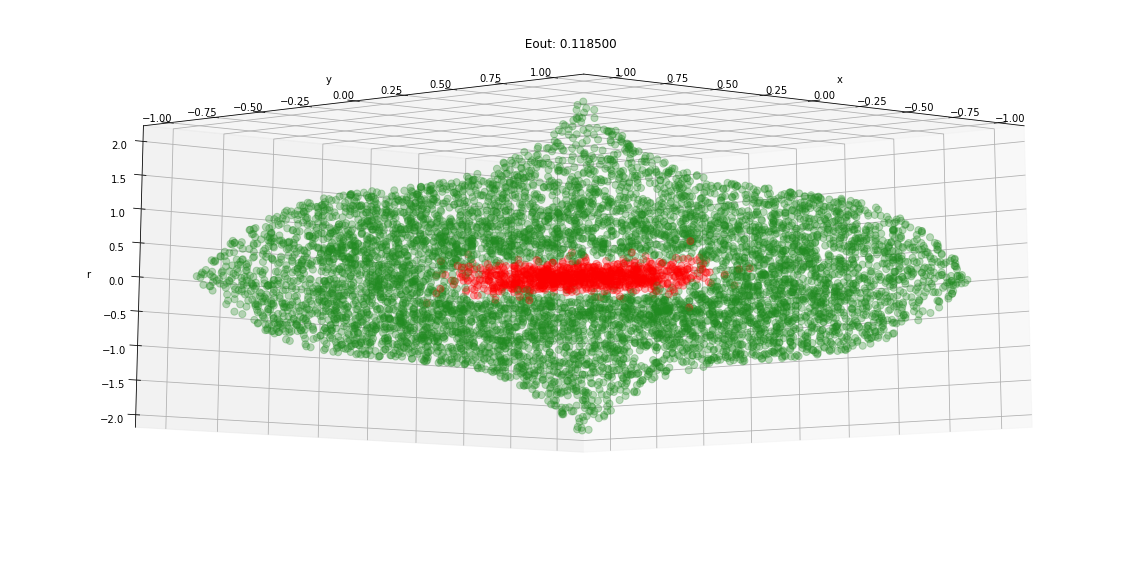

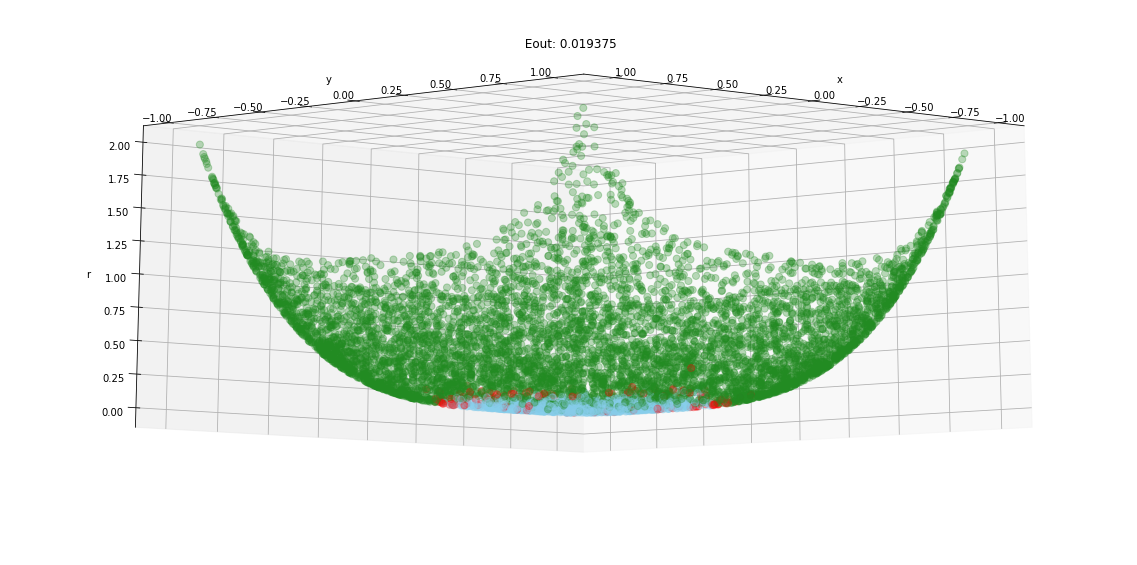

In [28]:
from mpl_toolkits import mplot3d

X,y = data['dataset_3'][0],data['dataset_3'][2]

def plot_3D(d,elev=-10, azim=45):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(projection='3d')
    r = (X[:, 0] ** d + X[:, 1] ** d)
    ax.scatter3D(X[:, 1], X[:, 0], r, c=c, s=50,alpha=0.3)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')
    ax.set_title(' Ein: {:2f}'.format(np.sum(diff)/len(diff)))
    plt.show()


for d in [2,3,4]:
    clf = svm.SVC(kernel='poly',gamma='auto',C=10,degree=d)
    clf.fit(X, y)
    y_hat = clf.predict(X)
    c = np.repeat('forestgreen', len(y))
    c[np.where(y!=1)] = 'skyblue'
    diff = np.not_equal(y,y_hat)
    c[diff] = 'red'
    plot_3D(d)

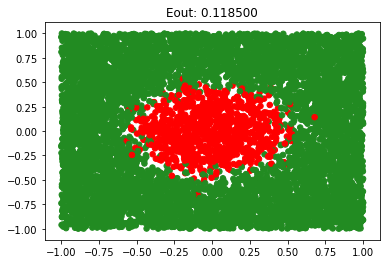

In [16]:
clf = svm.SVC(kernel='linear')
clf.fit(X, y)
y_hat = clf.predict(X)

c = np.repeat('forestgreen', len(y))
c[np.where(y!=1)] = 'skyblue'
diff = np.not_equal(y,y_hat)
c[diff] = 'red'


plt.scatter(X[:, 0], X[:, 1], c=c, s=30)
plt.title('Eout: {:2f}'.format(np.sum(diff)/len(diff)))
plt.show()